In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

C:\Users\SSSKA\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SSSKA\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\SSSKA\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df = pd.read_csv(r'D:\ML datasets\Heart attack prediction\heart.csv')

In [3]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.shape

(303, 14)

Separating Continuous and discrete features for preprocessing

In [5]:
continuous = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
discrete = list(set(df.columns[:-1])-set(continuous))
discrete

['restecg', 'fbs', 'cp', 'thall', 'caa', 'sex', 'slp', 'exng']

Missing values and duplicate rows

In [6]:
print("No. of missing values are ",df.isnull().values.sum())

No. of missing values are  0


In [7]:
print("No. of duplicate rows",sum(df.duplicated()))

No. of duplicate rows 1


In [8]:
df.loc[df.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [9]:
df = df.drop_duplicates()

In [10]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [11]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Check for Class imbalance

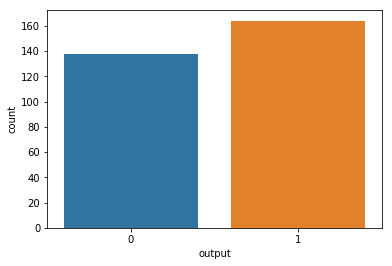

In [12]:
sns.countplot(df['output'])

There is very slight class imbalance and we can ignore it

# Anova and Chisquare test for feature selection

In [13]:
def anova_fs(col1, resp, df):
    input_ = col1 + '~' + resp
    model = ols(input_, data=df).fit()
    anv = sm.stats.anova_lm(model)
    return anv.iloc[0,-1]

In [14]:
def chisqre(col1, resp): 
    data_val = pd.crosstab(col1, resp).values
    r, c = data_val.shape
    dof = (r-1)*(c-1)
    exp_val = scipy.stats.chi2_contingency(data_val)
    freq = sum([(o-e)**2/e for o,e in zip(data_val, exp_val)])
    total = np.sum(np.array(freq))
    critical_c = scipy.stats.chi2.ppf(q = 1-alpha, df=dof)
    if total<critical_c:
        return 'discard'
    else:
        return 'select'

In [15]:
def spearman(col1,col2):
    return scipy.stats.spearmanr(col1,col2)[1]

In [17]:
final_cont = []
alpha=0.05
for i in continuous:
    p = anova_fs(i, 'output',df)
    if p<0.05:
        final_cont.append(i)
final_dis = []
for i in discrete:
    check = chisqre(df[i], df['output'])
    if check == 'select':
        final_dis.append(i)
features = final_cont+final_dis
features

['age',
 'trtbps',
 'thalachh',
 'oldpeak',
 'restecg',
 'fbs',
 'cp',
 'thall',
 'caa',
 'sex',
 'slp',
 'exng']

Chol feature is removed, lets see the pdf of chol w.r.t output

C:\Users\SSSKA\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\SSSKA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\SSSKA\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


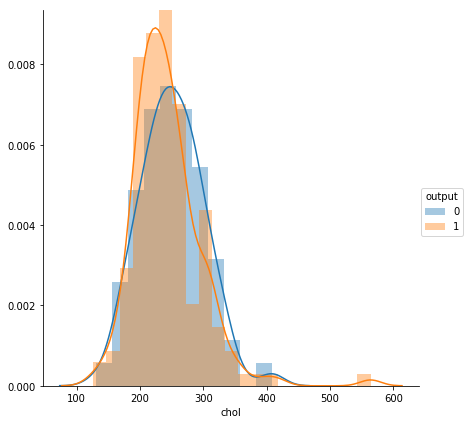

In [18]:
sns.FacetGrid(df, hue='output', size=6).map(sns.distplot, 'chol').add_legend()

From above PDF we can see that PDF's of both categories are almost overlapping, so model maynot make anything out of it. ANOVA showed that this feature is statistically insignificant.
So we can remove this feature

In [19]:
df_out = df['output'].copy()
df_in = df.drop(['output'], axis=1)
df_in.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [20]:
df_in = df_in.loc[:,features]
df_in.head(2)

,age,trtbps,thalachh,oldpeak,restecg,fbs,cp,thall,caa,sex,slp,exng
0,63,145,150,2.3,0,1,3,1,0,1,0,0
1,37,130,187,3.5,1,0,2,2,0,1,0,0


# Check for Correlation using VIF to remove correlated features

In [21]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [22]:
X = df_in.copy()

In [23]:
calc_vif(X)

,variables,VIF
0,age,35.814046
1,trtbps,57.960906
2,thalachh,39.344289
3,oldpeak,3.066930
4,restecg,2.027148
5,fbs,1.272211
6,cp,2.402527
7,thall,16.793119
8,caa,1.860020
9,sex,3.384688


In [513]:
X = X.drop(['age','trtbps', 'thalachh', 'thall'], axis=1)

We removed 4 features which has very high VIF

In [514]:
calc_vif(X)

,variables,VIF
0,oldpeak,2.088208
1,fbs,1.228073
2,restecg,1.950564
3,slp,3.745249
4,exng,1.796380
5,sex,3.024979
6,cp,2.108708
7,caa,1.707664


In [31]:
features = list(set(features)-set(['age','trtbps', 'thalachh', 'thall']))
features

['oldpeak', 'restecg', 'fbs', 'cp', 'caa', 'sex', 'slp', 'exng']

In [32]:
continuous = list(set(continuous).intersection(set(features)))
discrete = list(set(discrete).intersection(set(features)))
df_in_dis = df_in.loc[:,discrete]
df_in_con = df_in.loc[:,continuous]

One hot encoding discrete features

In [33]:
df_in_dis = pd.get_dummies(df_in_dis, prefix = discrete, columns=discrete)
df_in_dis.head(2)

,restecg_0,restecg_1,restecg_2,fbs_0,fbs_1,cp_0,cp_1,cp_2,cp_3,caa_0,...,caa_2,caa_3,caa_4,sex_0,sex_1,slp_0,slp_1,slp_2,exng_0,exng_1
0,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,0
1,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,1,1,0,0,1,0


Standardizing Continuous features

In [27]:
con_array = StandardScaler().fit_transform(df_in_con)
dis_array = df_in_dis.values

In [28]:
final_ar = np.hstack((con_array, dis_array))

Train test split

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(final_ar, df_out.values, random_state=42)

# Logistic Regression

In [34]:
parameters = {'penalty':['l1','l2'], 'C':[0.001,0.01,0.1,1,10]}
model = LogisticRegression(max_iter=1000)
lr_grid = GridSearchCV(model, param_grid=parameters, n_jobs=-1)
lr_grid.fit(X_train, Y_train)
Y_hat = lr_grid.predict(X_test)

C:\Users\SSSKA\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.54425121        nan 0.8094686         nan 0.85816425
        nan 0.84057971        nan 0.83613527]
  category=UserWarning


In [35]:
lr_grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [36]:
confusion_matrix(Y_test, Y_hat)

array([[33,  2],
       [ 6, 35]], dtype=int64)

In [37]:
print(classification_report(Y_test, Y_hat))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        35
           1       0.95      0.85      0.90        41

    accuracy                           0.89        76
   macro avg       0.90      0.90      0.89        76
weighted avg       0.90      0.89      0.89        76



# XGBOOST Classifier

In [530]:
parameters = {'eta':[0.0001,0.001,0.01,0.1,1,5,10], 'n_estimators':[20,30,40,50,60,70]}
model = XGBClassifier()
xgb_grid = GridSearchCV(model, param_grid=parameters,cv=3, n_jobs=-1)
xgb_grid.fit(X_train, Y_train)
Y_hat = xgb_grid.predict(X_test)

In [531]:
Y_hattr = xgb_grid.predict(X_train)

In [532]:
print(classification_report(Y_train, Y_hattr))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       103
           1       0.87      0.94      0.90       123

    accuracy                           0.89       226
   macro avg       0.89      0.88      0.89       226
weighted avg       0.89      0.89      0.89       226



In [533]:
xgb_grid.best_params_

{'eta': 0.0001, 'n_estimators': 30}

In [534]:
print(classification_report(Y_test, Y_hat))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        35
           1       0.85      0.83      0.84        41

    accuracy                           0.83        76
   macro avg       0.83      0.83      0.83        76
weighted avg       0.83      0.83      0.83        76



There is no overfitting as train and test accuracy does'nt differ much in XGBOOST but Logistic regression is working better than XGBOOST